In [86]:
import pandas as pd
from ultralytics import YOLO
import os
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont
from xml.etree.ElementTree import Element, SubElement, ElementTree, tostring
from xml.dom import minidom

In [87]:
# Load the custom LADaS model
model = YOLO('models/model-train-test.pt')

# Define your input and output folders
image_folder = 'sample/'
image_processed = 'sample_processed/'
alto_sample = 'alto_sample/'

# Create output directories if they don't exist
os.makedirs(image_processed, exist_ok=True)
os.makedirs(alto_sample, exist_ok=True)

In [88]:
def process_single_image(image_path, model, image_processed_dir, alto_sample_dir):
    """
    Processes a single image: detects areas, visualizes results, and saves ALTO XML.
    """
    # 1. Detect the areas
    results = model.predict(source=image_path, imgsz=1280, conf=0.25, verbose=False)
    
    detections = []
    
    # Get the image dimensions for ALTO XML
    img = Image.open(image_path)
    img_width, img_height = img.size
    
    # 2. Prepare for visualization and data extraction
    draw = ImageDraw.Draw(img)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()
    
    colors = {
        'MainZone-P': 'blue', 'MainZone-Head': 'red', 'DropCapitalZone': 'orange',
        'NumberingZone': 'yellow', 'RunningTitleZone': 'green', 'FigureZone': 'lime',
        'GraphicZone': 'magenta', 'StampZone': 'teal'
    }

    if results:
        for result in results:
            for box in result.boxes:
                class_name = result.names[int(box.cls.item())]
                confidence = box.conf.item()
                xyxy = box.xyxy[0].tolist()
                
                detections.append({'class_name': class_name, 'confidence': confidence,
                                   'x_min': xyxy[0], 'y_min': xyxy[1], 'x_max': xyxy[2], 'y_max': xyxy[3]})
                
                # Draw the bounding box and label
                color = colors.get(class_name, 'black')
                draw.rectangle(xyxy, outline=color, width=3)
                draw.text((xyxy[0], xyxy[1] - 20), f"{class_name} {confidence:.2f}", fill=color, font=font)

    # 3. Save the processed picture
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    processed_image_path = os.path.join(image_processed_dir, f"{base_name}_processed.jpg")
    img.save(processed_image_path)
    
    # 4. Save the results as ALTO XML
    detections_df = pd.DataFrame(detections)
    export_to_alto(detections_df, image_path, img_width, img_height, alto_sample_dir)
    
    print(f"✅ Processed {image_path}: saved image to {processed_image_path} and ALTO to {alto_sample_dir}.")


def export_to_alto(detections_df, image_path, img_width, img_height, output_dir):
    """
    Converts a DataFrame of detections to an ALTO XML file.
    """
    alto_file = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}.xml")
    
    alto_root = Element('alto', {'xmlns': 'http://www.loc.gov/standards/alto/ns-v4#', 'xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance', 'xsi:schemaLocation': 'http://www.loc.gov/standards/alto/ns-v4# http://www.loc.gov/standards/alto/v4/alto-4-2.xsd'})
    
    layout = SubElement(alto_root, 'Layout')
    page = SubElement(layout, 'Page', {
        'WIDTH': str(img_width), 
        'HEIGHT': str(img_height),
        'PHYSICAL_IMG_NR': '1',
        'ID': f"page_{os.path.basename(image_path)}"
    })
    
    print_space = SubElement(page, 'PrintSpace', {'HPOS': '0', 'VPOS': '0', 'WIDTH': str(img_width), 'HEIGHT': str(img_height)})
    
    # Iterate through detections and create a TextBlock for each
    for index, row in detections_df.iterrows():
        text_block = SubElement(print_space, 'TextBlock', {
            'HPOS': str(int(row['x_min'])),
            'VPOS': str(int(row['y_min'])),
            'WIDTH': str(int(row['x_max'] - row['x_min'])),
            'HEIGHT': str(int(row['y_max'] - row['y_min'])),
            'ID': f"block_{index}",
            'TYPE': row['class_name']
        })
        
        # Add a placeholder TextLine and String. Actual text requires OCR.
        text_line = SubElement(text_block, 'TextLine', {'ID': f"line_{index}"})
        SubElement(text_line, 'String', {'ID': f"string_{index}", 'CONTENT': '[text]'})
    
    # Pretty-print the XML and save it
    xml_str = tostring(alto_root, 'utf-8')
    parsed_str = minidom.parseString(xml_str)
    pretty_xml = parsed_str.toprettyxml(indent="  ")
    
    with open(alto_file, "w", encoding="utf-8") as f:
        f.write(pretty_xml)

In [89]:
# --- Main Script Execution ---
if __name__ == "__main__":
    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif'))]

    if not image_files:
        print(f"⚠️ No images found in '{image_folder}'. Please check the folder path and file types.")
    else:
        print(f"Starting batch processing for {len(image_files)} images...")
        for image_path in tqdm(image_files, desc="Processing Images"):
            process_single_image(image_path, model, image_processed, alto_sample)
        print("🎉 Batch processing complete!")

Starting batch processing for 5 images...


Processing Images:  20%|██        | 1/5 [00:00<00:01,  2.03it/s]

✅ Processed sample/sample_page_iconologia_page5.jpg: saved image to sample_processed/sample_page_iconologia_page5_processed.jpg and ALTO to alto_sample/.


Processing Images:  40%|████      | 2/5 [00:00<00:01,  2.41it/s]

✅ Processed sample/sample_page_iconologia_page4.jpg: saved image to sample_processed/sample_page_iconologia_page4_processed.jpg and ALTO to alto_sample/.


Processing Images:  60%|██████    | 3/5 [00:01<00:00,  2.61it/s]

✅ Processed sample/sample_page_iconologia_page3.jpg: saved image to sample_processed/sample_page_iconologia_page3_processed.jpg and ALTO to alto_sample/.


Processing Images:  80%|████████  | 4/5 [00:01<00:00,  2.68it/s]

✅ Processed sample/sample_page_iconologia_page2.jpg: saved image to sample_processed/sample_page_iconologia_page2_processed.jpg and ALTO to alto_sample/.


Processing Images: 100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

✅ Processed sample/29432253.jpg: saved image to sample_processed/29432253_processed.jpg and ALTO to alto_sample/.
🎉 Batch processing complete!


In [80]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from PIL import Image
import os, random
from ultralytics import YOLO
import fileinput

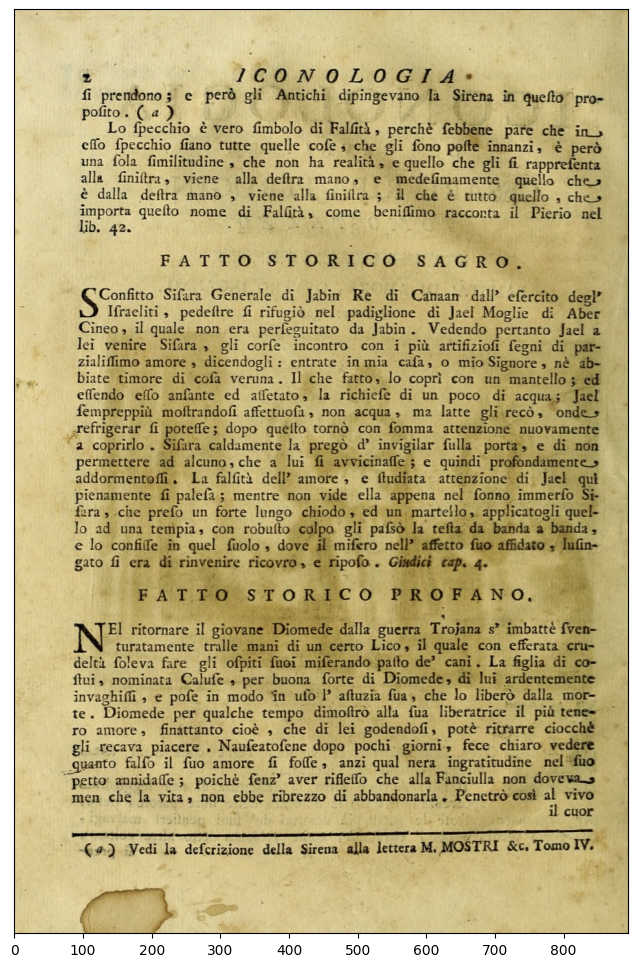

In [81]:
image = mpimg.imread("sample/sample_page_iconologia_page2.jpg")
plt.figure(figsize=(30, 12), dpi=100)
plt.imshow(image)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

 The image randomly chosen is: sample/ sample_page_iconologia_page3.jpg


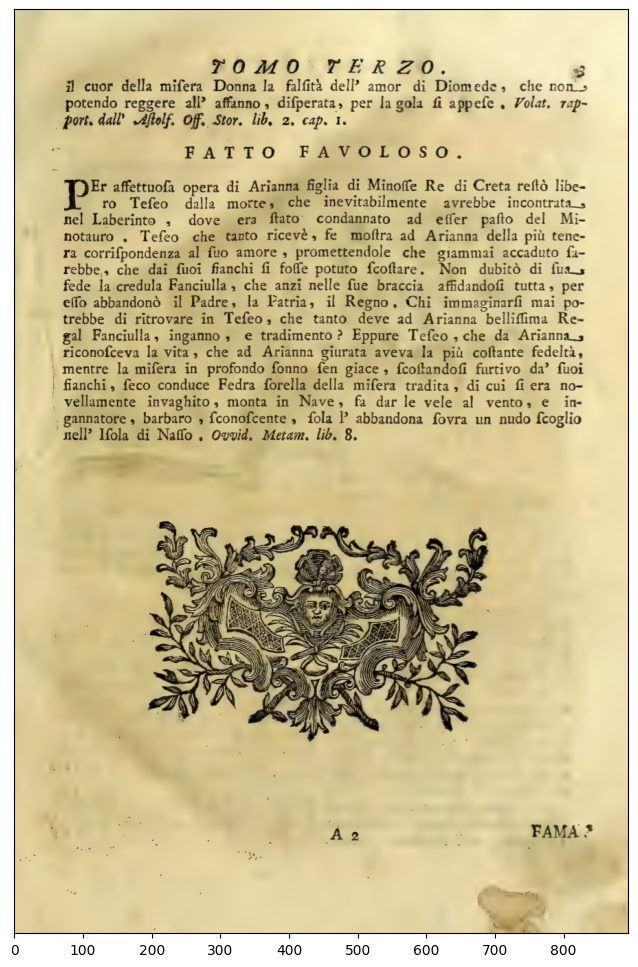

In [82]:
path="sample/"
# Choose an image
img = random.choice(os.listdir(path))
#Print filename chose
print('\033[92m The image randomly chosen is:',path,img)
# Prediction
image = mpimg.imread(os.path.join(path,img))
# Plot the result
plt.figure(figsize=(30, 12), dpi=100)
plt.imshow(image)
plt.gca().axes.get_yaxis().set_visible(False)
plt.show()

In [83]:
# Load the model
model = YOLO("models/model-train-test.pt")
# Use GPU if you have one (comment with # if you don't, typically on your machine)
# model.to('cuda')
# Get info about the model
model.info()
# Fuse PyTorch Conv2d and BatchNorm2d layers. This improves inference time and therefore execution time.
model.fuse()


 The image randomly chosen is: sample/ sample_page_iconologia_page5.jpg


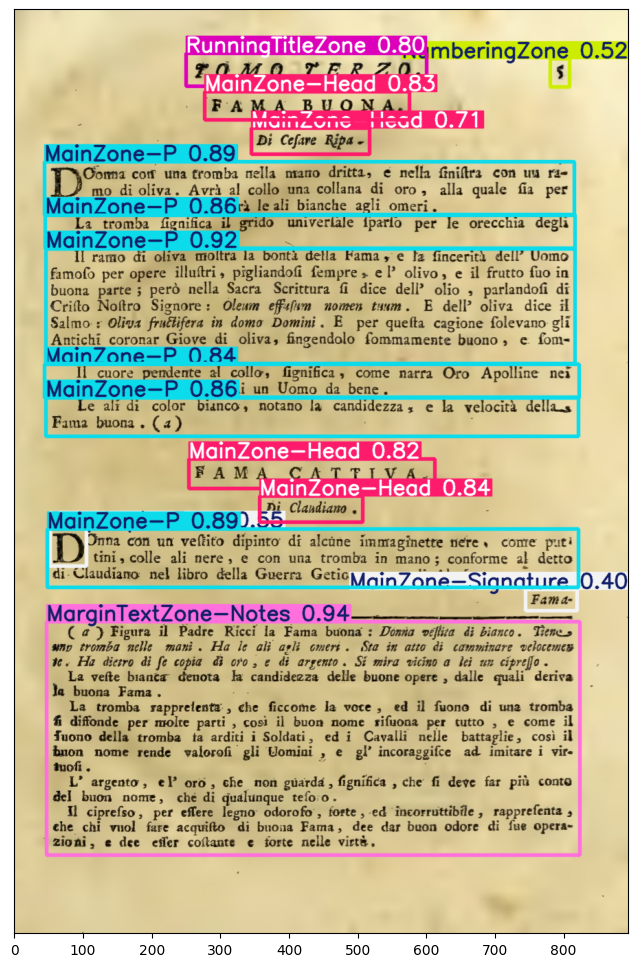

In [84]:
#get folder
path="sample/"
# Choose an image
img = random.choice(os.listdir(path))
#Print filename chose
print('\033[92m The image randomly chosen is:',path,img)
# Prediction
results = model(os.path.join(path,img))
# Plot the result
for r in results:
    im_array = r.plot(conf=True)  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    plt.figure(figsize=(30, 12), dpi=100)
    plt.imshow(im)
    plt.gca().axes.get_yaxis().set_visible(False)
    plt.show()

In [85]:
!yaltai kraken --device cpu -I "sample/*.jpg" --suffix ".xml" segment --yolo models/model-train-test.pt
print('\033[92m Segmentation done!')

Loading ANN /opt/homebrew/Caskroom/miniforge/base/envs/icon/lib/python3.10/site-packages/kraken/blla.mlmodel	Segmenting sample/sample_page_iconologia_page5.jpg	
image 1/1 /Users/carboni/Documents/pynotebook/personal/12.01 Iconographical Canon/Processing/sample/sample_page_iconologia_page5.jpg: 1280x864 1 DropCapitalZone, 4 MainZone-Heads, 6 MainZone-Ps, 1 MainZone-Signature, 1 MarginTextZone-Notes, 1 NumberingZone, 1 RunningTitleZone, 865.6ms
Speed: 9.5ms preprocess, 865.6ms inference, 5.1ms postprocess per image at shape (1, 3, 1280, 864)
✓
Segmenting sample/sample_page_iconologia_page4.jpg	
image 1/1 /Users/carboni/Documents/pynotebook/personal/12.01 Iconographical Canon/Processing/sample/sample_page_iconologia_page4.jpg: 1280x864 1 DropCapitalZone, 1 GraphicZone, 1 GraphicZone-Head, 2 MainZone-Heads, 6 MainZone-Ps, 1 NumberingZone, 1 RunningTitleZone, 1 StampZone, 868.6ms
Speed: 3.8ms preprocess, 868.6ms inference, 0.8ms postprocess per image at shape (1, 3, 1280, 864)
✓
Segmenting 

In [77]:
for file in os.listdir(os.path.join("alto_sample")):
    if file.endswith(".xml"):
      with fileinput.FileInput(os.path.join("alto_sample", file), inplace=True) as f:
        for line in f:
          print(line.replace('alto_sample/', ''), end='')
print('\033[92m All files are corrected!')

 All files are corrected!


In [78]:
!kraken --alto --suffix ".xml" -I "alto_sample/*.xml" -f alto ocr -m "models/catmus-print-fondue-large.mlmodel"

Loading ANN models/catmus-print-fondue-large.mlmodel	✓
[09/04/25 15:24:14] ERROR    Failed processing                     ]8;id=824349;file:///opt/homebrew/Caskroom/miniforge/base/envs/icon/lib/python3.10/site-packages/kraken/kraken.py\kraken.py]8;;\:]8;id=129037;file:///opt/homebrew/Caskroom/miniforge/base/envs/icon/lib/python3.10/site-packages/kraken/kraken.py#447\447]8;;\
                             alto_sample/sample_page_iconologia_pa              
                             ge5.xml: No valid image filename                   
                             found in ALTO file                                 
                             alto_sample/sample_page_iconologia_pa              
                             ge5.xml                                            
                    ERROR    Failed processing                     ]8;id=292126;file:///opt/homebrew/Caskroom/miniforge/base/envs/icon/lib/python3.10/site-packages/kraken/kraken.py\kraken.py]8;;\:]8;id=12

In [ ]:
!mkdir -p sample/data/doc_1
!mv sample/*.xml sample/data/doc_1
print('\033[92m All files are transcribed!')